# Assumptions of Linear Regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
plt.style.use('seaborn-notebook')

Underlying linear regression is what we've been seeing all along: an hypothesis test. And just as we make assumptions in order to draw conclusions from the results of our hypothesis tests, so too linear regression makes assumptions about the data used in constructing the analysis.

## Learning Objectives

- Construct plots to test whether a dataset satisfies the assumptions of linear regression
- Calculate and use statistics to test the same
- Transform variables when necessary to better meet the assumptions of linear regression

## General Strategy When Finding Violations of Assumptions

No model is perfect, and your assumptions will never hold perfectly. If the violations of assumptions are severe, you can try adjusting the data so the assumptions will hold, such as by:

- Transforming your data with a non-linear function (e.g. $log$)
- Only modeling a subset of your data
- Dropping outliers

These can make it harder to explain or interpret your model, but the trade-off may be worth it. Alternatively, you may be better of just using a different type of model (you will learn many).

Let's dig deeper.

## Regression Model of Diamond Price

In preparation for putting these assumptions to the test, let's set up a linear regression.

In [3]:
diamonds = sns.load_dataset('diamonds')

In [4]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
diamonds.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

In [6]:
X = diamonds.select_dtypes(float) # only select the float type
ss = StandardScaler().fit(X)

X_scaled = ss.transform(X)

In [7]:
X_c = sm.add_constant(X_scaled) # ols stat models add_constant or other version adds it automatically, called intercept
y = diamonds['price']

In [8]:
model = sm.OLS(endog=y, exog=X_c).fit()

## 1. Linearity

**The relationship between the target and predictors is linear.** This is of course the fundamental and most obvious assumption of the linear model.

### How to Check

One way to check this is by drawing a scatter plot of your predictions as a function of your residuals. Ideally, we'll see a linear relationship here.

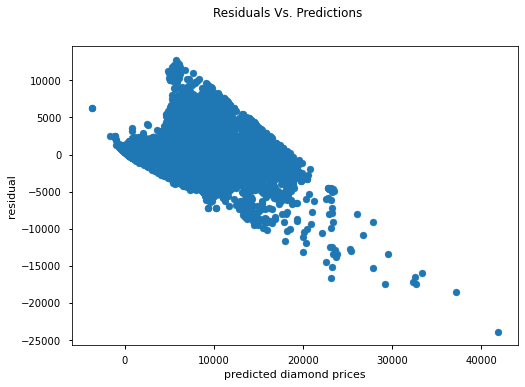

In [9]:
model_preds = model.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted diamond prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');
# linear relationship

#### Target Vs. Predictor Plot

Why don't we just plot the target vs. one of our features? Well, we can. Let's try it here with a couple features.

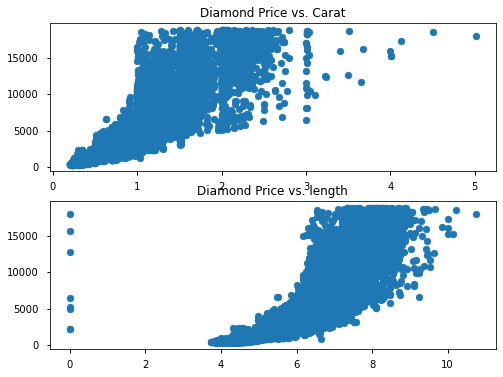

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

ax1.scatter(X['carat'], y)
ax1.set_title('Diamond Price vs. Carat')
ax2.scatter(X['x'], y)
ax2.set_title('Diamond Price vs. length');
# not straight , curved


There are definitely correlations here, although these perhaps look more like curves than lines!

However, we have to be careful in using this strategy to test for linearity.

Consider the following (tiny) example:

Suppose our target $Z$ is (approximately) a linear combination of the two variables $X$ and $Y$, and in fact can be described as $Z = 2X + 3Y + \epsilon$.

Suppose further that our data-sampling process has produced an unfortunate result:

In [11]:
training_X_values = [1, 2, 3]
training_Y_values = [1, 2, 8]

In this case, even though $Z$ is a linear combination of the variables $X$ and $Y$, it is *not* a linear function of $X$ alone. The bad luck here is that:
- $Y$-values increase with $X$-values, but
- this change in $Y$ won't show up on a $Z$-vs.-$X$ plot!

In [12]:
np.random.seed(42)

target = [2*x + 3*y + np.random.rand() for x, y in zip(training_X_values, training_Y_values)]

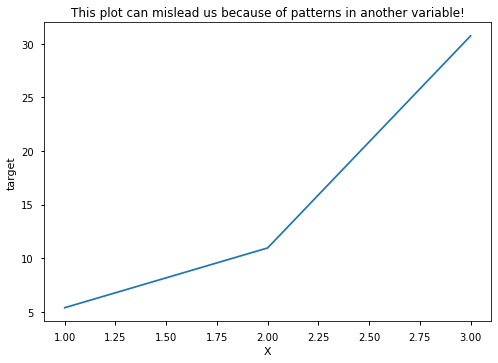

In [13]:
fig, ax = plt.subplots()

ax.plot(training_X_values, target)
ax.set_xlabel('X')
ax.set_ylabel('target')
ax.set_title('This plot can mislead us because of patterns in another variable!');
# little elbow in the graph

This graph may lead us to doubt that our target is not usefully modeled as a linear combination of features, when in fact we are seeing this non-linearity only because of a chance correlation between $X$ (plotted here) and $Y$ (not taken into account by this plot at all).

See also the Level Up below on `statsmodels.graphics.plot_regress_exog()`.

### And if it Fails the Check?

If the relationship between predictors and target is non-linear, then we'll need either a different sort of model altogether or a linear regression with some non-linear terms. Most obviously, we could try adding some **polynomial terms** such as $X_1X_2$ or $X_3^4$, but if we have a reason (because of some helpful EDA) to suspect a different type of relationship, we could also try more exotic transformations, such as $sin(X_1)$ or $e^{-X_5}$.

## 2. Independence

**The errors are independent**. In other words: Knowing the error for one point doesn't tell you anything about the error for another. With correlated errors our model will tend to underestimate the errors around our betas, and so we run the risk of **false positive** conclusions about the significance of variables. See [here](https://towardsdatascience.com/linear-regression-assumptions-why-is-it-important-af28438a44a1).

### How to Check

- Make a scatter plot of the residuals and target values and look for patterns
- Check the value of the Durbin-Watson statistic.

#### Scatter Plot

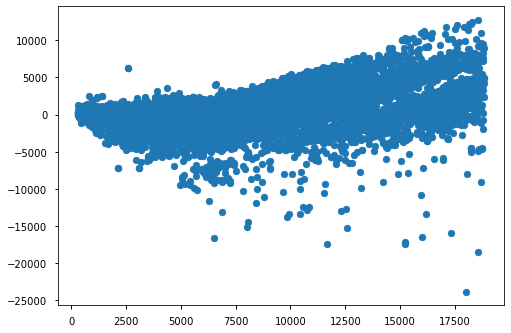

In [14]:
fig, ax = plt.subplots()

ax.scatter(y, resids);
# positive correlation in the errors
# you don't want correlation, you want independent,
#either the data is not good for linear , or need to drop outliers to approach linearity, or ...


If there is a natural sequence of our errors we can also make a plot of "consecutive errors" to check for patterns. See [this video](https://www.youtube.com/watch?v=-hmv4fshvBU).

The upward trend in this plot suggests a slight *positive* correlation in our errors.

#### Durbin-Watson

The Durbin-Watson test statistic is calculated on the null hypothesis that there is no correlation among the errors. The test statistic has a range of 0 to 4, where 2 indicates no correlation, a score less than 2 indicates a positive correlation, and a score greater than 2 indicates a negative correlation.

In [15]:
dw = sm.stats.stattools.durbin_watson

In [16]:
dw(resids)

1.249374575242534

In [17]:
model.summary().tables[2]

Omnibus:,14093.399,Durbin-Watson:,1.249
Prob(Omnibus):,0.000,Jarque-Bera (JB):,373568.966
Skew:,0.674,Prob(JB):,0.00
Kurtosis:,15.822,Cond. No.,17.3


As we suspected, we have a positive correlation here.

### And if it Fails the Check?

If there are trends in our errors, the general strategy is to try to **model** those trends. We'll come back to this idea when we explore time-series modeling.

## 3. Normality

**The errors are normally distributed.** That is, smaller errors are more probable than larger errors, according to the familiar bell curve. This is basically a conseqence of the Central Limit Theorem. If an error is a sum of influences from a large collection of (untracked!) variables, then the CLT assures us that that sum will have a normal distribution, regardless of the distributions of the untracked variables themselves.

### How to Check

- Make a histogram of the residuals
- Build a QQ-Plot
- Check the Jarque-Bera or Omnibus p-value (from `statsmodels` output)

#### Histograms

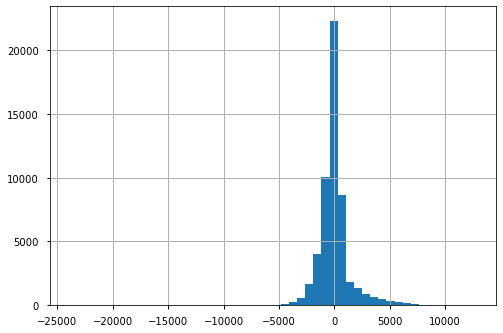

In [18]:
resids.hist(bins=50);
# residuals look normal

To eliminate the outliers from the plot we might try zooming in on the center:

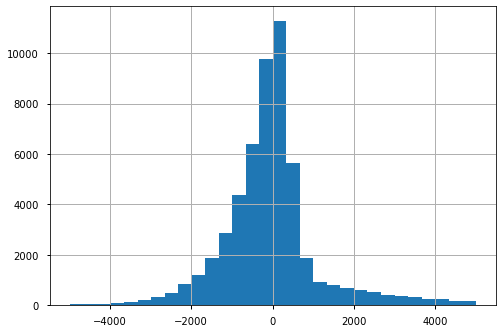

In [19]:
resids[abs(resids) < 5000].hist(bins=30);
# fairly normal

These look fairly normal.

#### QQ Plot

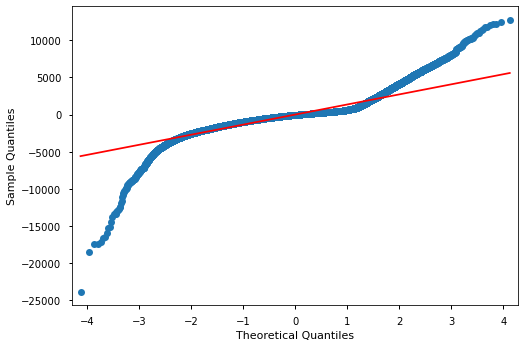

In [20]:
sm.qqplot(resids, line='r');
# not normal, 

When the errors are normal, they will follow the diagonal line closely. Here we see some significant divergences.

#### Statistical Tests

The null hypothesis for the Jarque-Bera Test is that errors are normally distributed. Here we have a huge test statistic and tiny p-value. So we have to reject this null hypothesis. Similarly, the `statsmodels` Omnibus test tests for skewness and kurtosis (see [here](https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate)), and so we are looking for small numbers. But again we see the opposite.

In [21]:
model.summary().tables[2]
# error are not normally distributed, tiny p value(JB)

Omnibus:,14093.399,Durbin-Watson:,1.249
Prob(Omnibus):,0.000,Jarque-Bera (JB):,373568.966
Skew:,0.674,Prob(JB):,0.00
Kurtosis:,15.822,Cond. No.,17.3


### And if it Fails the Check?

Non-normal errors are often the result of non-normal variables. In the present case, we note the exponential distribution of the target itself:

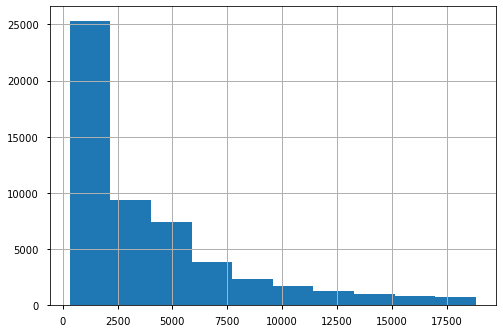

In [25]:
y.hist();
# np.log() - to make it more more normal, takes away the skewness to normalize the data
#np.log(y).hist();

So a good idea here would be to transform the target, perhaps with a logarithm, and then try the model again. This is an exercise below.

## 4. Homoskedasticity

**The errors are homoskedastic (or homos$\underline{c}$edastic).** That is, the errors have the same variance. 

(The Greek word $\sigma\kappa\epsilon\delta\acute{\alpha}\nu\nu\upsilon\mu\iota$ means "to scatter".)

If errors are not homoskedastic, betas will have larger errors, leading to a greater risk of **false negative** conclusions about the significance of variables. Once again, see [this post](https://towardsdatascience.com/linear-regression-assumptions-why-is-it-important-af28438a44a1).

### How to Check

- Make a scatter plot of the residuals and target values and look to see if they are more or less spread out at different places
- There are also statistical tests for this such as Goldfeld-Quandt (`sm.stats.diagnostic.het_goldlfeldquandt`) and Breusch-Pagan (`sm.stats.diagnostic.het_breuschpagan`).

#### Scatter Plot

We reproduce the plot from above, when we checked for independence of errors:

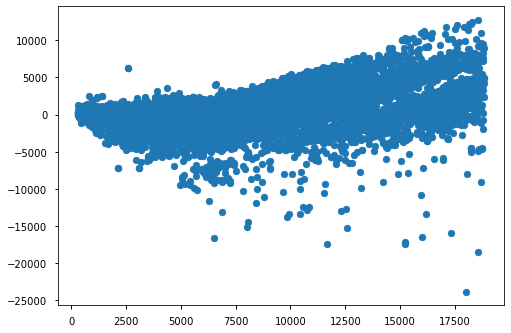

In [23]:
fig, ax = plt.subplots()

ax.scatter(y, resids);
# errors are faning out, fanning occure or cone,heteroskedasticity, key indicator of a violation,
# have to apply some transformation , np.log(), to deal with this and make it homoskedasticity

See how the errors get more spread out with larger values of the target? That's **heteroskedasticity**, the opposite of what we're looking for.

### And if it Fails the Check?

Often when errors are heteroskedastic they will be greater for greater values of the target. If the target has an exponential distribution, with lots of small values and few large values, then the model will tend to focus on the smaller values in calculating its betas, producing volatility for the higher end of the spectrum. And so we'll see greater divergence in the errors for larger values of the target.

This is exactly what we see here. In such a case it can help to apply some transformation to the target that will rein in the larger values.

### Exercise

Build a residual plot and a QQ Plot for a new model, this time with the (natural) logarithm of price as the target. Do the residuals look more normally distributed? Do they look more homoskedastic?

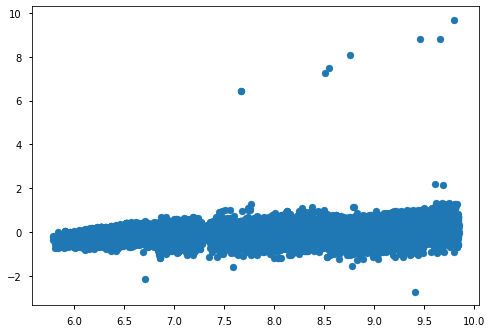

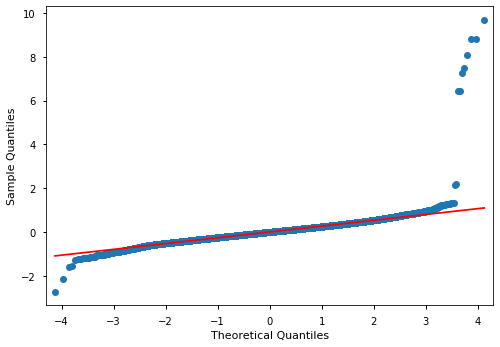

In [26]:
y_log = np.log(y)
model2 = sm.OLS(endog=y_log, exog=X_c).fit()
model2_preds = model2.predict(X_c)
model2_resids = y_log - model2_preds
# Residual Plot
fig, ax = plt.subplots()
ax.scatter(y_log, model2_resids)
# QQ Plot
sm.qqplot(model2_resids, line='r');

# variance closer to the ...
# looks closer to normal

<details>
    <summary> Answer </summary>
<code>y_log = np.log(y)
model2 = sm.OLS(endog=y_log, exog=X_c).fit()
model2_preds = model2.predict(X_c)
model2_resids = y_log - model2_preds
# Residual Plot
fig, ax = plt.subplots()
ax.scatter(y_log, model2_resids)
# QQ Plot
sm.qqplot(model2_resids, line='r');</code>
<br/>Yes, they look better!
    </details>

## 5. Predictors Are Independent: No *Multicollinearity*

A further assumption for *multiple* linear regression is that **the predictors are independent**. Multicollinearity refers to a correlation between distinct predictors. Why might high multicollinearity be a problem for interpreting a linear regression model?

It's problematic for statistics in an inferential mode because, if $x_1$ and $x_2$ are highly correlated with $y$ but also *with each other*, then it will be very difficult to tease apart the effects of $x_1$ on $y$ and the effects of $x_2$ on $y$. If I really want to have a good sense of the effect of $x_1$ on $y$, then I'd like to vary $x_1$ while keeping the other features constant. But if $x_1$ is highly correlated with $x_2$ then this will be a practically impossible exercise!

Statistically speaking, when variables are correlated then *so will the associated betas*, and thus the betas will be highly volatile and have large errors, again leading to an increased risk of **false negative** conclusions about the significance of variables. See again [here](https://towardsdatascience.com/linear-regression-assumptions-why-is-it-important-af28438a44a1).

Suppose that the predictor $x_2$ is a function of the predictor $x_1$. That is, suppose that $y = \beta_1x_1 + \beta_2x_2 + \beta_0$ and $x_2 = \beta_{\phi}x_1 + k$.

In that case the $x_2$ variable is otiose since we'd have:

$\begin{align}y &= \beta_1x_1 + \beta_2x_2 + \beta_0 \\ &= \beta_1x_1 + \beta_2(\beta_{\phi}x_1 + k) + \beta_0 \\ &= \beta_1\beta_2\beta_{\phi}x_1 + (\beta_2k + \beta_0) \\ &= \beta_ax_1 + \beta_b \end{align}$,

for $\beta_a = \beta1\beta_2\beta_{\phi}$ and $\beta_b = \beta_2k + \beta_0$.

### How to Check

- Check the model Condition Number.
- Check the correlation values.
- Compute Variance Inflation Factors ([VIFs](https://www.statsmodels.org/devel/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)).

#### Condition Number

[Formally](https://en.wikipedia.org/wiki/Condition_number), the condition number is a measure of the volatility in the output of a function given a small change in the input.

In the case of linear regression what is calculated is the condition number of the *correlation matrix* of the data. This number represents the volatility of the linear action of the matrix and so, since correlated variables will produce greater volatility, is effectively a measure of multicollinearity.

The condition number of a matrix is related to its *eigendecomposition*. We'll return to this concept in later lessons.

<details>
    <summary> Click here for more details </summary>
<code>corr_mat = np.corrcoef(X_scaled, rowvar=False)
eigvals = np.linalg.eig(corr_mat)[0]
cond_no = np.sqrt(eigvals.max()) / np.sqrt(eigvals.min())
cond_no</code>
    </details>

In [27]:
model.summary().tables[2]
# cond. no (17.3) below 1000 means heavey correlation

Omnibus:,14093.399,Durbin-Watson:,1.249
Prob(Omnibus):,0.000,Jarque-Bera (JB):,373568.966
Skew:,0.674,Prob(JB):,0.00
Kurtosis:,15.822,Cond. No.,17.3


Our condition number is well below the danger zone around 1000 or so, so by this test we don't seem to have strongly interdependent variables.

#### Correlation Values

Let's use a `pandas` DataFrame so we can see things more clearly.

In [28]:
# code challenge
df = pd.DataFrame(X_scaled, columns=X.columns)
corrs = df.corr()
corrs
# drop carat, y, z, or play arround which one gives you a best result

,carat,depth,table,x,y,z
carat,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929
x,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000


When we look at this matrix we do see some high values (off of the main diagonal). The spatial dimension variables (`x`, `y`, and `z`) are highly correlated with each other and with `carat`. We might consider dropping some of these in a final model.

#### VIFs

The idea of a [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) is to gauge how much the error around a beta for a particular variable is increased because of multicollinearity. Surprisingly, this can be measured by regressing the predictor in question **against the other predictors** and then calculating $\frac{1}{1-R^2}$ for that model.

Notice that, if we're dealing with a variable $x_1$ that is highly correlated with another, then the other predictors will be good at predicting $x_1$. This means that the model will have a high $R^2$ score, which means in turn that the VIF will be large. If the variable can't at all be predicted by the others, then the model we produce will have an $R^2$ of 0, in which case the VIF will have a value of 1.

Let's try this for the `table` variable:

In [29]:
vif_model = sm.OLS(endog=df['table'], exog=sm.add_constant(df.drop('table', axis=1))).fit()
vif_table = 1 / (1-vif_model.rsquared)
vif_table
# we want low vif , it it's more than 5, you might one to cut it

1.1432245465275204

That looks like a healthily low VIF.

### Exercise

Compute the VIF for the `x` variable. What conclusion should we draw from this value?

In [30]:
vif_model = sm.OLS(endog=df['x'], exog=sm.add_constant(df.drop('x', axis=1))).fit()
vif_table = 1 / (1-vif_model.rsquared)
vif_table
# x variable , you need to cut x, as it over correlated 

56.187704355141435

<details>
    <summary> Answer </summary>
<code>vif_model = sm.OLS(endog=df['x'], exog=sm.add_constant(df.drop('x', axis=1))).fit()
vif_table = 1 / (1-vif_model.rsquared)
vif_table</code> <br/>
The other predictors are highly correlated with `x` and so probably `x` should be dropped in a final model.</details>

### And if it Fails the Check?

The most straightforward thing to do is to drop predictors that are strongly correlated with others.

We might in our case consider building a model that drops `x`, `y`, and `z` altogether.

> Multicollinearity will be a recurring theme. For more, see [this post](https://towardsdatascience.com/https-towardsdatascience-com-multicollinearity-how-does-it-create-a-problem-72956a49058) and [this slide deck](https://www.sjsu.edu/faculty/guangliang.chen/Math261a/Ch9slides-multicollinearity.pdf).

[Here](https://towardsdatascience.com/linear-regression-assumptions-why-is-it-important-af28438a44a1) is a helpful resource for more on these assumptions. See also [this page](https://www.statisticssolutions.com/assumptions-of-linear-regression/).

## Level Up: `statsmodels.graphics.plot_regress_exog()`

Observe the return of this function:

eval_env: 1


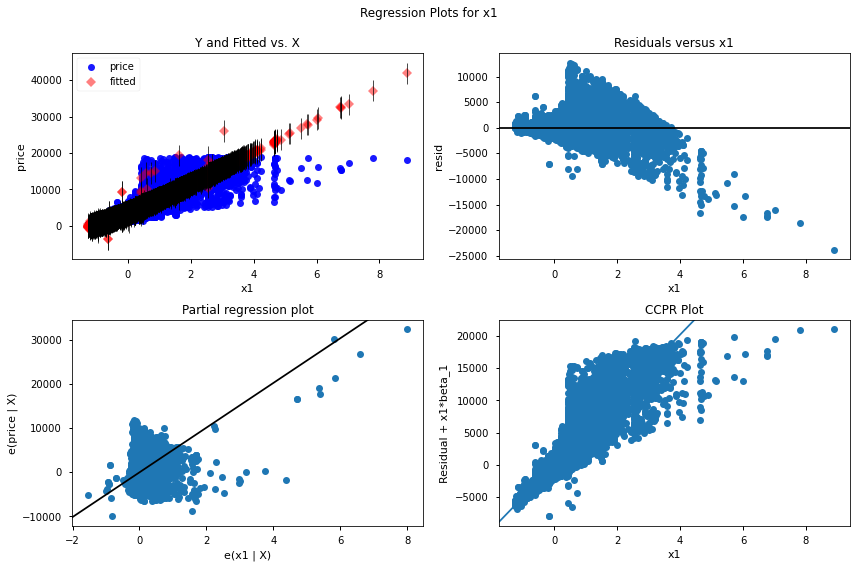

In [31]:
# 'x1' is the carat variable
sm.graphics.plot_regress_exog(model, 'x1', fig=plt.figure(figsize=(12, 8)));

What are these four plots?

- "Y and Fitted vs. X": This shows actual target values vs. predictions. Notice:
    - the predictions have error bars that reflect the errors reported in the model summary
    - the predictions do not form a perfect line since we have other predictors in the model.
- "Residuals versus x1": Imagine taking the last plot and rotating it so that the prediction line is the x-axis. This plot shows how far off our model's predictions are as a function of the input. Remember that such plots can tell us about whether our model satisfies the assumption that our errors are homoskedastic.
- ["Partial regression plot"](https://en.wikipedia.org/wiki/Partial_regression_plot): This plots the residuals of a model of price given everything except x1 vs. the residuals of a model of x1 given everything except x1. This sort of plot can be especially useful for locating outliers as well as checking our regression assumptions. Note that the slope of the line is equal to $\beta_1$.
- ["CCPR Plot"](https://en.wikipedia.org/wiki/Partial_residual_plot): "Component-and-component-plus-residual Plot". This shows the best-fit line for x1 and the residuals of the model as a whole.